## Prepare data

In [ ]:
!unzip /content/drive/My\ Drive/PhySim.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: PhySim_Full/Phy031_Render5_0060.png  
  inflating: PhySim_Full/Phy038_Render1_0057.png  
  inflating: PhySim_Full/Phy038_Render3_0057.png  
  inflating: PhySim_Full/Phy038_Render5_0057.png  
  inflating: PhySim_Full/Phy045_Render1_0054.png  
  inflating: PhySim_Full/Phy045_Render3_0054.png  
  inflating: PhySim_Full/Phy045_Render5_0054.png  
  inflating: PhySim_Full/Phy052_Render1_0051.png  
  inflating: PhySim_Full/Phy052_Render3_0051.png  
  inflating: PhySim_Full/Phy052_Render5_0051.png  
  inflating: PhySim_Full/Phy052_Render5_0067.png  
  inflating: PhySim_Full/Phy052_Render5_0083.png  
  inflating: PhySim_Full/Phy052_Render5_0099.png  
  inflating: PhySim_Full/Phy052_Render5_0115.png  
  inflating: PhySim_Full/Phy052_Render6_0011.png  
  inflating: PhySim_Full/Phy052_Render6_0027.png  
  inflating: PhySim_Full/Phy052_Render6_0043.png  
  inflating: PhySim_Full/Phy052_Render6_0059.png  
  inflating: PhySim_Full/Phy052_Render6_0075.png  
  in

## Import

In [ ]:
import os
import random
import time
from collections import defaultdict
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import classification_report
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader

## Dataset

1. try new dataset
2. use more images
3. use larger latent size

#### Resize the image

In [ ]:
data_dir = 'data'
if not os.path.exists(data_dir):
  os.mkdir(data_dir)
length = len(os.listdir('./PhySim_Full'))
for i, file in enumerate(os.listdir('./PhySim_Full')):
  im = Image.open(os.path.join('./PhySim_Full', file))
  im = im.resize((256, 256))
  im.save(os.path.join(data_dir, file))
  if i > 0 and i % 100 == 0:
    print('current resize: ', i, 'total: ', length) 

current resize:  100 total:  10001
current resize:  200 total:  10001
current resize:  300 total:  10001
current resize:  400 total:  10001
current resize:  500 total:  10001
current resize:  600 total:  10001
current resize:  700 total:  10001
current resize:  800 total:  10001
current resize:  900 total:  10001
current resize:  1000 total:  10001
current resize:  1100 total:  10001
current resize:  1200 total:  10001
current resize:  1300 total:  10001
current resize:  1400 total:  10001
current resize:  1500 total:  10001
current resize:  1600 total:  10001
current resize:  1700 total:  10001
current resize:  1800 total:  10001
current resize:  1900 total:  10001
current resize:  2000 total:  10001
current resize:  2100 total:  10001
current resize:  2200 total:  10001
current resize:  2300 total:  10001
current resize:  2400 total:  10001
current resize:  2500 total:  10001
current resize:  2600 total:  10001
current resize:  2700 total:  10001
current resize:  2800 total:  10001
c

#### Generate labels

In [ ]:
# data_dir = './PhySim_Full'
label_dir = './labels'
vae_dir = './labels/vae'
vae_train_dir = './labels/vae/train_label.csv'
vae_test_dir = './labels/vae/test_label.csv'
vae_validate_dir = './labels/vae/validate_label.csv'

num_images = 5
regression_dir = './labels/regression'
regression_train_dir = './labels/regression/train_label.csv'
regression_test_dir = './labels/regression/test_label.csv'
regression_validate_dir = './labels/regression/validate_label.csv'

all_file_dir = './labels/all.csv'
if not os.path.exists(label_dir):
  os.mkdir(label_dir)
if not os.path.exists(vae_dir):
  os.mkdir(vae_dir)
if not os.path.exists(regression_dir):
  os.mkdir(regression_dir)

random.seed(1000)
classes_ = [ 24, 52, 80, 101]
file_list = [f for f in os.listdir('PhySim_Full') 
        if int(f.replace('.png', '').split('_')[0][3:])in classes_]
          # and int(f.replace('.png', '').split[1][6:]) > 20]
random.shuffle(file_list)

# generate vae labels
labels = []
for file in file_list:
  labels.append(file+'\n')
train_test_boundary = int(len(labels)*0.8)
test_validate_boundary = int(len(labels)*0.95)
with open(all_file_dir, 'w') as fin:
  fin.writelines(labels)
with open(vae_train_dir, 'w') as fin:
  fin.writelines(labels[:train_test_boundary])
with open(vae_test_dir, 'w') as fin:
  fin.writelines(labels[train_test_boundary:test_validate_boundary])
with open(vae_validate_dir, 'w') as fin:
  fin.writelines(labels[test_validate_boundary:])

# generate regression labels
file_dict = defaultdict(list)
for file in file_list:
  sp = file.replace('.png', '').split('_')
  stiffness = int(sp[0][3:])
  render = int(sp[1][6:])
  file_dict[(stiffness, render)].append(file)

label_dict = defaultdict(list)
for key in file_dict.keys():
  fl = sorted(file_dict[key], key=lambda x: int(x.replace('.png', '').split('_')[-1]))
  for i in range(len(fl)-num_images):
    line = ''
    for j in range(num_images):
      line += fl[i+j] + ','
      if j == num_images -1:
        line += str(key[0]) + '\n'
    rand = random.randint(1, 100)
    if rand <= 80:
      label_dict['train'].append(line)
    elif rand <= 95:
      label_dict['test'].append(line)
    else:
      label_dict['validate'].append(line)


if not os.path.exists(regression_dir):
  os.mkdir(regression_dir)
with open(regression_train_dir, 'w') as fin:
  fin.writelines(label_dict['train'])
with open(regression_test_dir, 'w') as fin:
  fin.writelines(label_dict['test'])
with open(regression_validate_dir, 'w') as fin:
  fin.writelines(label_dict['validate'])

#### For VAE

In [ ]:
class VAEDataset(Dataset):
  """ VAE dataset """

  def __init__(self, data_dir, csv_dir, transform=None):
    self.data_dir = data_dir
    self.data_names = pd.read_csv(csv_dir, header=None)
    self.transform = transform

  def __len__(self):
    return int(len(self.data_names))

  def __getitem__(self, idx):
    image_dir = os.path.join(self.data_dir, str(self.data_names.values[idx, 0]))
    image = Image.open(image_dir)
    if self.transform:
      image = self.transform(image)
    return {'image': image, 'label': str(self.data_names.values[idx, 0])}

#### For Regression


In [ ]:
class RegressionDataset(Dataset):
  """ Regression dataset """

  def __init__(self, data_dir, csv_dir, transform=None):
    self.data_dir = data_dir
    self.data_names = pd.read_csv(csv_dir, header=None)
    self.transform = transform
  
  def __len__(self):
    return int(len(self.data_names))

  def __getitem__(self, idx):
    data = self.data_names.values[idx]
    images_dict = {}
    for i, name in enumerate(data[:-1]):
      image_dir = os.path.join(self.data_dir, str(name))
      image = Image.open(image_dir)
      if self.transform:
        image = self.transform(image)
      images_dict[i] = image
    images_dict['label'] = data[-1]

    return images_dict

## Convolutional VAE

#### Model

In [ ]:
#@title
class ConvVAE(nn.Module):
  """ VAE """

  def __init__(self, img_channels, latent_size):
    super(ConvVAE, self).__init__()
    self.encoder = Encoder(img_channels, latent_size)
    self.decoder = Decoder(img_channels, latent_size)

  def forward(self, x):
    mu, log_sigma = self.encoder(x)
    sigma = log_sigma.exp()
    eps = torch.randn_like(sigma)
    z = eps.mul(sigma).add_(mu)

    recon_x = self.decoder(z)
    return recon_x, mu, sigma


class Encoder(nn.Module):
  """ VAE encoder """

  def __init__(self, img_channels, latent_size):
    super(Encoder, self).__init__()
    self.latent_size = latent_size
    self.img_channels = img_channels

    self.conv1 = nn.Conv2d(img_channels, 32, 4, stride=2)
    self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
    self.conv3 = nn.Conv2d(64, 128, 4, stride=2)
    self.conv4 = nn.Conv2d(128, 256, 4, stride=2)

    self.fc_mu = nn.Linear(6*6*256, latent_size)
    self.fc_log_sigma = nn.Linear(6*6*256, latent_size)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))

    x = x.view(x.size(0), -1)

    mu = self.fc_mu(x)
    log_sigma = self.fc_log_sigma(x)

    return mu, log_sigma


class Decoder(nn.Module):
  """ VAE decoder"""

  def __init__(self, img_channels, latent_size):
    super(Decoder, self).__init__()
    self.latent_size = latent_size
    self.img_channels = img_channels

    self.fc1 = nn.Linear(latent_size, 65536)
    self.deconv1 = nn.ConvTranspose2d(65536, 128, 5, stride=2)
    self.deconv2 = nn.ConvTranspose2d(128, 64, 5, stride=2)
    self.deconv3 = nn.ConvTranspose2d(64, 32, 6, stride=2)
    self.deconv4 = nn.ConvTranspose2d(32, img_channels, 6, stride=2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    print(x.shape)
    x = x.unsqueeze(-1).unsqueeze(-1)
    x = F.relu(self.deconv1(x))
    x = F.relu(self.deconv2(x))
    x = F.relu(self.deconv3(x))
    reconstruction = F.sigmoid(self.deconv4(x))
    print(reconstruction.shape)
    return reconstruction

In [ ]:
class ConvVAE(nn.Module):
  """ VAE """

  def __init__(self, img_channels, latent_size):
    super(ConvVAE, self).__init__()
    self.encoder = Encoder(img_channels, latent_size)
    self.decoder = Decoder(img_channels, latent_size)

  def forward(self, x):
    mu, log_sigma = self.encoder(x)
    sigma = log_sigma.exp()
    eps = torch.randn_like(sigma)
    z = eps.mul(sigma).add_(mu)

    recon_x = self.decoder(z)
    return recon_x, mu, sigma


class Encoder(nn.Module):
  """ VAE encoder """

  def __init__(self, img_channels, latent_size):
    super(Encoder, self).__init__()
    self.latent_size = latent_size
    self.img_channels = img_channels

    self.conv1 = nn.Conv2d(img_channels, 32, 4, padding=True, stride=2)
    self.conv2 = nn.Conv2d(32, 64, 4, padding=True, stride=2)
    self.conv3 = nn.Conv2d(64, 128, 4, padding=True, stride=2)
    self.conv4 = nn.Conv2d(128, 256, 4, padding=True, stride=2)

    self.fc_mu = nn.Linear(256*8*8, latent_size)
    self.fc_log_sigma = nn.Linear(256*8*8, latent_size)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = x.view(x.size(0), -1)

    mu = self.fc_mu(x)
    log_sigma = self.fc_log_sigma(x)
    return mu, log_sigma


class Decoder(nn.Module):
  """ VAE decoder"""

  def __init__(self, img_channels, latent_size):
    super(Decoder, self).__init__()
    self.latent_size = latent_size
    self.img_channels = img_channels

    self.fc1 = nn.Linear(latent_size, 256*8*8)
    self.deconv1 = nn.ConvTranspose2d(256, 128, 4, padding=True, stride=2)
    self.deconv2 = nn.ConvTranspose2d(128, 64, 4, padding=True, stride=2)
    self.deconv3 = nn.ConvTranspose2d(64, 32, 4, padding=True, stride=2)
    self.deconv4 = nn.ConvTranspose2d(32, img_channels, 4, padding=True, stride=2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = x.view([-1, 256, 8, 8])
    x = F.relu(self.deconv1(x))
    x = F.relu(self.deconv2(x))
    x = F.relu(self.deconv3(x))
    reconstruction = F.sigmoid(self.deconv4(x))

    return reconstruction

In [ ]:
class EarlyStopping(object):
    """
    Gives a criterion to stop training when a given metric is not
    improving anymore
    Args:
    mode (str): One of `min`, `max`. In `min` mode, training will
        be stopped when the quantity monitored has stopped
        decreasing; in `max` mode it will be stopped when the
        quantity monitored has stopped increasing. Default: 'min'.
    patience (int): Number of epochs with no improvement after
        which training is stopped. For example, if
        `patience = 2`, then we will ignore the first 2 epochs
        with no improvement, and will only stop learning after the
        3rd epoch if the loss still hasn't improved then.
        Default: 10.
    threshold (float): Threshold for measuring the new optimum,
        to only focus on significant changes. Default: 1e-4.
    threshold_mode (str): One of `rel`, `abs`. In `rel` mode,
        dynamic_threshold = best * ( 1 + threshold ) in 'max'
        mode or best * ( 1 - threshold ) in `min` mode.
        In `abs` mode, dynamic_threshold = best + threshold in
        `max` mode or best - threshold in `min` mode. Default: 'rel'.
    """

    def __init__(self, mode='min', patience=10, threshold=1e-4, threshold_mode='rel'):
      self.patience = patience
      self.mode = mode
      self.threshold = threshold
      self.threshold_mode = threshold_mode
      self.best = None
      self.num_bad_epochs = None
      self.mode_worse = None  # the worse value for the chosen mode
      self.is_better = None
      self.last_epoch = -1
      self._init_is_better(mode=mode, threshold=threshold,
                            threshold_mode=threshold_mode)
      self._reset()

    def _reset(self):
      """Resets num_bad_epochs counter and cooldown counter."""
      self.best = self.mode_worse
      self.num_bad_epochs = 0

    def step(self, metrics, epoch=None):
      """ Updates early stopping state """
      current = metrics
      if epoch is None:
        epoch = self.last_epoch = self.last_epoch + 1
      self.last_epoch = epoch

      if self.is_better(current, self.best):
        self.best = current
        self.num_bad_epochs = 0
      else:
        self.num_bad_epochs += 1

    @property
    def stop(self):
      """ Should we stop learning? """
      return self.num_bad_epochs > self.patience

    def _cmp(self, mode, threshold_mode, threshold, a, best):  # pylint: disable=R0913, R0201
      if mode == 'min' and threshold_mode == 'rel':
        rel_epsilon = 1. - threshold
        return a < best * rel_epsilon

      elif mode == 'min' and threshold_mode == 'abs':
        return a < best - threshold

      elif mode == 'max' and threshold_mode == 'rel':
        rel_epsilon = threshold + 1.
        return a > best * rel_epsilon

      return a > best + threshold

    def _init_is_better(self, mode, threshold, threshold_mode):
      if mode not in {'min', 'max'}:
        raise ValueError('mode ' + mode + ' is unknown!')
      if threshold_mode not in {'rel', 'abs'}:
        raise ValueError('threshold mode ' + threshold_mode + ' is unknown!')

      if mode == 'min':
        self.mode_worse = float('inf')
      else:  # mode == 'max':
        self.mode_worse = (-float('inf'))

      self.is_better = partial(self._cmp, mode, threshold_mode, threshold)

    def state_dict(self):
      """ Returns early stopping state """
      return {key: value for key, value in self.__dict__.items() if key != 'is_better'}

    def load_state_dict(self, state_dict):
      """ Loads early stopping state """
      self.__dict__.update(state_dict)
      self._init_is_better(mode=self.mode, threshold=self.threshold,
                            threshold_mode=self.threshold_mode)

#### Helper function

In [ ]:
def loss_function(recon_x, x, mu, log_sigma):
    """
    VAE loss function
    :param recon_x: reconstructed image
    :param x: image
    :param mu: mean of latent factor
    :param log_sigma: standard deviation of latent factor
    :return: loss
    """
    # MSE for batch
    # recon_x = recon_x.view([-1, 1, 256, 256])
    BCE = F.mse_loss(recon_x, x, size_average=False)
    # KL divergence
    KLD = -0.5 * torch.sum(1 + 2 * log_sigma - mu.pow(2) - (2 * log_sigma).exp())
    loss = BCE + KLD

    return loss

In [ ]:
def train(model, loader, epoch):
  """ Train the model """
  model.train()
  train_loss = 0.0
  epoch_start = time.time()

  for batch, data in enumerate(loader):
    optimizer.zero_grad()
    image = data['image'].to(device)
    recon_batch, mu, sigma = model(image)
    loss = loss_function(recon_batch, image, mu, sigma)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
    if batch % 20 == 0:
        print('Train epoch: {}, batch: {}, loss: {}, time: {}'
        .format(epoch, batch, loss, time.time() - epoch_start))

  avg_loss = train_loss / len(loader.dataset)
  print('Finish training epoch {}, average loss: {}, in {} seconds'.format(epoch, avg_loss, time.time() - epoch_start))

  return avg_loss

In [ ]:
def test(model, loader, epoch, is_save=False, result_dir=None):
  """ Test the model """
  model.eval()
  test_loss = 0
  epoch_start = time.time()

  with torch.no_grad():
    for batch, data in enumerate(loader):
      image = data['image'].to(device)
      recon_batch, mu, sigma = model(image)
      test_loss += loss_function(recon_batch, image, mu, sigma)
      if is_save:
        if batch % 20 == 0:
          print('Saving {} batch images in {} seconds'.format(batch, time.time() - epoch_start))
        for recon, label in zip(recon_batch, data['label']):
          image_name = label
          image_dir = os.path.join(result_dir, image_name)
          save_image(recon.to('cpu'), image_dir)

  avg_loss = test_loss / len(loader.dataset)
  if not is_save:
    print('Finish testing epoch {}, average loss: {}, in {} seconds'.format(epoch, avg_loss, time.time() - epoch_start))
  else:
    print('Finish generate final result at', result_dir)

  return avg_loss

In [ ]:
def save_checkpoint(loss_state, best_state, is_best, filename, best_filename):
  """
  Save vae1 and store the best vae1
  :param loss_state: loss of each epoch
  :param best_state: dict of model, include parameters and states
  :param is_best: boolean, mark if the vae1 is the best
  :param filename: filename to save
  :param best_filename: the filename of best vae1
  :return: None
  """
  torch.save(loss_state, filename)
  if is_best:
    torch.save(best_state, best_filename)

#### Train

In [ ]:
# Training parameters
epochs = 1000
batch_size = 32
vae_checkpoint_dir = '/content/drive/My Drive/checkpoint_vae'
best_checkpoint = 'best.pth'
result_dir = './reconstruction_images'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(1000)
torch.manual_seed(1000)

if not os.path.exists(vae_checkpoint_dir):
  os.mkdir(vae_checkpoint_dir)
if not os.path.exists(result_dir):
  os.mkdir(result_dir)

In [ ]:
# Load dataset
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_dataset = VAEDataset(data_dir, vae_train_dir, data_transforms)
test_dataset = VAEDataset(data_dir, vae_test_dir, data_transforms)
validate_dataset = VAEDataset(data_dir, vae_validate_dir)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True, num_workers=16)

In [ ]:
# Model Setting
vae = ConvVAE(img_channels=1, latent_size=128).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
earlystopping = EarlyStopping('min', patience=30)
print('Initializing model:\n', vae)

Initializing model:
 ConvVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(True, True))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(True, True))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(True, True))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(True, True))
    (fc_mu): Linear(in_features=16384, out_features=128, bias=True)
    (fc_log_sigma): Linear(in_features=16384, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=128, out_features=16384, bias=True)
    (deconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(True, True))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(True, True))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(True, True))
    (deconv4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding

In [ ]:
# Loading model checkpoint
checkpoint_count = len(os.listdir(vae_checkpoint_dir))
reload_dir = os.path.join(vae_checkpoint_dir, best_checkpoint)
best_loss = None

if os.path.exists(reload_dir):
  best_state = torch.load(reload_dir)
  print('Reloading vae......, file: ', reload_dir)
  vae.load_state_dict(best_state['state_dict'])
  optimizer.load_state_dict(best_state['optimizer_dict'])
  scheduler.load_state_dict(best_state['scheduler_dict'])
  earlystopping.load_state_dict(best_state['earlystopping_dict'])
  best_loss = best_state['best_loss']
  # delete useless parameter to get more gpu memory
  del best_state
else:
  print('There is no checkpoint to load! Start the first epoch!')

Reloading vae......, file:  /content/drive/My Drive/checkpoint_vae/best.pth


In [ ]:
# Train and validate
for epoch in range(epochs):
  train_loss = train(vae, train_loader, checkpoint_count)
  scheduler.step(train_loss)
  earlystopping.step(train_loss)
  test_loss = test(vae, test_loader, checkpoint_count)
  is_best = not best_loss or test_loss < best_loss
  if is_best:
    best_loss = test_loss

  loss_state = {'epoch': checkpoint_count,
          'train_loss': train_loss,
          'test_loss': test_loss}
  best_state = {'epoch': checkpoint_count,
          'state_dict': vae.state_dict(),
          'encoder_dict': vae.encoder.state_dict(),
          'optimizer_dict': optimizer.state_dict(),
          'scheduler_dict': scheduler.state_dict(),
          'earlystopping_dict': earlystopping.state_dict(),
          'train_loss': train_loss,
          'test_loss': test_loss,
          'best_loss': best_loss}
  checkpoint_name = os.path.join(vae_checkpoint_dir, str(checkpoint_count) + '.pth')
  save_checkpoint(loss_state, best_state, is_best, checkpoint_name, reload_dir)
  checkpoint_count += 1

#### Generate reconstruction images

In [ ]:
reload_dir = os.path.join(vae_checkpoint_dir, best_checkpoint)
best_state = torch.load(reload_dir)
print('Loading the best vae......')
print('Start generate samples......')
vae.load_state_dict(best_state['state_dict'])
# delete useless parameter to get more gpu memory
del best_state
all_dataset = VAEDataset(data_dir, all_file_dir, data_transforms)
all_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
test(vae, all_loader, 0, is_save=True, result_dir=result_dir)

Loading the best vae......
Start generate samples......


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Saving 0 batch images in 0.8159687519073486 seconds
Saving 20 batch images in 3.291858673095703 seconds
Saving 40 batch images in 5.717006683349609 seconds
Saving 60 batch images in 8.104589939117432 seconds
Saving 80 batch images in 10.441479682922363 seconds
Finish generate final result at ./reconstruction_images


tensor(0.8009, device='cuda:0')

#### Visualization


{'epoch': 10, 'train_loss': 21.42063661302839, 'test_loss': tensor(22.1353)}
{'epoch': 11, 'train_loss': 19.706992081233434, 'test_loss': tensor(20.2803)}
{'epoch': 12, 'train_loss': 18.32632235118321, 'test_loss': tensor(18.6565)}
{'epoch': 13, 'train_loss': 18.14327516555786, 'test_loss': tensor(18.1699)}
{'epoch': 14, 'train_loss': 16.592336790902273, 'test_loss': tensor(17.1459)}
{'epoch': 15, 'train_loss': 15.821790776933943, 'test_loss': tensor(16.2258)}
{'epoch': 16, 'train_loss': 15.241459614889962, 'test_loss': tensor(15.5311)}
{'epoch': 17, 'train_loss': 14.536162499019078, 'test_loss': tensor(14.8940)}
{'epoch': 18, 'train_loss': 14.096523680005754, 'test_loss': tensor(14.9445)}
{'epoch': 19, 'train_loss': 13.45425431387765, 'test_loss': tensor(13.7181)}
{'epoch': 20, 'train_loss': 12.747330175127303, 'test_loss': tensor(13.0973)}
{'epoch': 21, 'train_loss': 12.318826484680176, 'test_loss': tensor(12.8450)}
{'epoch': 22, 'train_loss': 12.671710245949882, 'test_loss': tensor(

Text(0, 0.5, 'loss')

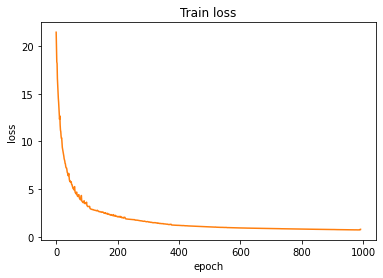

In [ ]:
# Loss
checkpoints = {int(checkpoint.replace('.pth', '')): checkpoint
          for checkpoint in os.listdir(vae_checkpoint_dir)
          if 'best' not in checkpoint}
train_losses = []
test_losses = []
for key in sorted(list(checkpoints.keys()))[10:]:
  checkpoint = checkpoints[key]
  state = torch.load(os.path.join('/content/drive/My Drive/checkpoint_vae', checkpoint), map_location='cpu')
  print(state)
  # train_losses.append(state['train_loss'])
  test_losses.append(state['train_loss'])

plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Train loss')
plt.xlabel('epoch')
plt.ylabel('loss')

Phy080_Render2_0021.png Phy052_Render6_0011.png


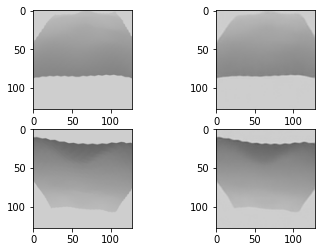

In [ ]:
fig, axes = plt.subplots(2, 2)
file1 = os.listdir(os.path.join(result_dir))[random.randint(0, 1000)]
file2 = os.listdir(os.path.join(result_dir))[random.randint(0, 1000)]
print(file1, file2)
im = Image.open(os.path.join(data_dir, file1))
im = im.convert('LA')
axes[0, 0].imshow(im)
im = Image.open(os.path.join(result_dir, file1))
axes[0, 1].imshow(im)
im = Image.open(os.path.join(data_dir, file2))
im = im.convert('LA')
axes[1, 0].imshow(im)
im = Image.open(os.path.join(result_dir, file2))
axes[1, 1].imshow(im)

#### Save checkpoints to zip file

In [ ]:
!zip -r ./checkpoint_vae_128x128_128_1000.zip /content/drive/My\ Drive/checkpoint_vae
!mv ./checkpoint_vae_128x128_128_1000.zip /content/drive/My\ Drive/checkpoint_vae_128x128_128_1000.zip

  adding: content/drive/My Drive/checkpoint_vae/ (stored 0%)
  adding: content/drive/My Drive/checkpoint_vae/541.pth (deflated 52%)
  adding: content/drive/My Drive/checkpoint_vae/542.pth (deflated 52%)
  adding: content/drive/My Drive/checkpoint_vae/543.pth (deflated 52%)
  adding: content/drive/My Drive/checkpoint_vae/544.pth (deflated 52%)
  adding: content/drive/My Drive/checkpoint_vae/545.pth (deflated 52%)
  adding: content/drive/My Drive/checkpoint_vae/546.pth (deflated 52%)
  adding: content/drive/My Drive/checkpoint_vae/547.pth (deflated 52%)
  adding: content/drive/My Drive/checkpoint_vae/548.pth (deflated 52%)
  adding: content/drive/My Drive/checkpoint_vae/549.pth (deflated 52%)
  adding: content/drive/My Drive/checkpoint_vae/550.pth (deflated 52%)
  adding: content/drive/My Drive/checkpoint_vae/551.pth (deflated 52%)
  adding: content/drive/My Drive/checkpoint_vae/552.pth (deflated 52%)
  adding: content/drive/My Drive/checkpoint_vae/553.pth (deflated 52%)
  adding: conten

## Regression

#### Model

In [ ]:
class RegressionEncoder(nn.Module):

  def __init__(self, img_channels, latent_size):
    super(RegressionEncoder, self).__init__()
    self.encoder = Encoder(img_channels, latent_size)

  def forward(self, x):
    mu1, log_sigma1 = self.encoder(x[0])
    mu2, log_sigma2 = self.encoder(x[1])
    mu3, log_sigma3 = self.encoder(x[2])
    mu4, log_sigma4 = self.encoder(x[3])
    mu5, log_sigma5 = self.encoder(x[4])

    sigma = torch.cat((log_sigma1.exp(), log_sigma2.exp(), log_sigma3.exp(),
                       log_sigma4, log_sigma5), -1)
    mu = torch.cat((mu1, mu2, mu3, mu4, mu5), -1)
    eps = torch.randn_like(sigma)
    z = eps.mul(sigma).add_(mu)

    return z

class SimpleRegression(nn.Module):

  def __init__(self, latent_size, num_images):
    super(SimpleRegression, self).__init__()
    self.fc1 = nn.Linear(num_images*latent_size, latent_size)
    self.fc2 = nn.Linear(latent_size, 32)
    self.fc3 = nn.Linear(32, 4)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.sigmoid(self.fc3(x))

    return x

#### Helper function

In [ ]:
def train(encoder, model, loader, criterion, epoch, latent_size, num_images):
  model.train()
  train_loss = 0.0
  epoch_start = time.time()

  for batch, data in enumerate(loader):
    optimizer.zero_grad()
    with torch.no_grad():
      images = [data[0].to(device), data[1].to(device), data[2].to(device),
                data[3].to(device), data[4].to(device)]
      z = encoder(images).view(-1, num_images*latent_size)
      
    outputs = model(z)
    targets = label_encoder.transform(data['label'])
    targets = torch.from_numpy(targets).to(device)
    loss = criterion(outputs, targets)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
    if batch % 20 == 0:
      print('Train epoch: {}, batch: {}, loss: {}, time: {}'
          .format(epoch, batch, loss, time.time() - epoch_start))

  avg_loss = train_loss / len(loader.dataset)
  print('Finish training epoch {}, average loss: {}, in {} seconds'
      .format(epoch, avg_loss, time.time() - epoch_start))

  return avg_loss

In [ ]:
def test(encoder, model, loader, criterion, epoch, latent_size, num_images, is_save=False):
  model.eval()
  test_loss = 0.0
  epoch_start = time.time()
  accuracy = 0.0
  if is_save:
    results = []
    true_labels = []

  with torch.no_grad():
    for batch, data in enumerate(loader):
      images = [data[0].to(device), data[1].to(device), data[2].to(device),
                data[3].to(device), data[4].to(device)]
      z = encoder(images).view(-1, num_images*latent_size)
      outputs = model(z)
      _, preds = torch.max(outputs, 1)
      targets = label_encoder.transform(data['label'])
      targets_ = torch.from_numpy(targets).to(device)
      loss = criterion(outputs, targets_)
      test_loss += loss.item()
      for p, t in zip(preds, targets):
        if p == t:
          accuracy += 1

      if is_save:
        true_labels.extend(targets)
        results.extend(preds.cpu().numpy())
      if batch % 20 == 0:
        print('Test epoch: {}, batch: {}, loss: {}, time: {}'
            .format(epoch, batch, loss, time.time() - epoch_start))
        print('Example outputs: ', preds)

  avg_loss = test_loss / len(loader.dataset)
  avg_acc = accuracy / len(loader.dataset)
  if is_save:
    print(classification_report(true_labels, results))
    results = label_encoder.inverse_transform(results)
    np.savetxt(os.path.join(result_dir, 'result.csv'), results, delimiter=',')
  else:
    print('Finish testing epoch {}, average loss: {}, average accuracy: {}, in {} seconds'
        .format(epoch, avg_loss, avg_acc, time.time() - epoch_start))

  return avg_loss

#### Train

In [ ]:
# Training parameters
epochs = 100
batch_size = 32
regression_checkpoint_dir = '/content/drive/My Drive/checkpoint_regression'
best_checkpoint = 'best.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_size = 128
lr = 1e-3
np.random.seed(1000)
torch.manual_seed(1000)

if not os.path.exists(regression_checkpoint_dir):
  os.mkdir(regression_checkpoint_dir)

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(list(classes_))
print('classes: ', label_encoder.classes_)

classes:  [ 24  52  80 101]


In [ ]:
# Load dataset
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_dataset = RegressionDataset(data_dir, regression_train_dir, data_transforms)
test_dataset = RegressionDataset(data_dir, regression_test_dir, data_transforms)
validate_dataset = RegressionDataset(data_dir, regression_validate_dir, data_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True, num_workers=16)

In [ ]:
# Model setting
encoder = RegressionEncoder(1, 128).to(device)
model = SimpleRegression(128, 5).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()
print('Initializing model:\n', encoder, '\n', model)

Initializing model:
 RegressionEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(True, True))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(True, True))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(True, True))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(True, True))
    (fc_mu): Linear(in_features=16384, out_features=128, bias=True)
    (fc_log_sigma): Linear(in_features=16384, out_features=128, bias=True)
  )
) 
 SimpleRegression(
  (fc1): Linear(in_features=640, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


In [ ]:
# Load model checkpoint
checkpoint_count = len(os.listdir(regression_checkpoint_dir))
reload_dir = os.path.join(regression_checkpoint_dir, best_checkpoint)
encoder_state = torch.load(os.path.join(vae_checkpoint_dir, best_checkpoint), map_location='cpu')
encoder.encoder.load_state_dict(encoder_state['encoder_dict'])
del encoder_state
best_loss = None

if os.path.exists(reload_dir):
  best_state = torch.load(reload_dir)
  print('Reloading vae1......, file: ', reload_dir)
  model.load_state_dict(best_state['state_dict'])
  optimizer.load_state_dict(best_state['optimizer_dict'])
  best_loss = best_state['best_loss']
  # delete useless parameter to get more gpu memory
  del best_state
else:
  print('There is no checkpoint to load! Start the first epoch!')

Reloading vae1......, file:  /content/drive/My Drive/checkpoint_regression/best.pth


In [ ]:
for epoch in range(epochs):
  train_loss = train(encoder, model, train_loader, loss_function, checkpoint_count, latent_size, num_images)
  test_loss = test(encoder, model, test_loader, loss_function, checkpoint_count, latent_size, num_images)
  is_best = not best_loss or test_loss < best_loss
  if is_best:
      best_loss = test_loss

  loss_state = {'epoch': checkpoint_count,
          'train_loss': train_loss,
          'test_loss': test_loss}
  best_state = {'epoch': checkpoint_count,
          'state_dict': model.state_dict(),
          'optimizer_dict': optimizer.state_dict(),
          'train_loss': train_loss,
          'test_loss': test_loss,
          'best_loss': best_loss}
  checkpoint_name = os.path.join(regression_checkpoint_dir, str(checkpoint_count) + '.pth')
  save_checkpoint(loss_state, best_state, is_best, checkpoint_name, reload_dir)
  checkpoint_count += 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train epoch: 1101, batch: 0, loss: 0.850216269493103, time: 0.833989143371582
Train epoch: 1101, batch: 20, loss: 0.8386579155921936, time: 2.4800524711608887
Train epoch: 1101, batch: 40, loss: 0.8599929213523865, time: 3.0935051441192627
Train epoch: 1101, batch: 60, loss: 0.8982419371604919, time: 3.450697898864746
Finish training epoch 1101, average loss: 0.02766778461202226, in 3.6949563026428223 seconds
Test epoch: 1101, batch: 0, loss: 0.8623177409172058, time: 0.7885189056396484
Example outputs:  tensor([2, 0, 0, 0, 1, 3, 2, 0, 2, 3, 0, 0, 2, 0, 3, 1, 3, 3, 3, 1, 0, 1, 2, 1,
        1, 3, 1, 1, 2, 3, 2, 3], device='cuda:0')
Finish testing epoch 1101, average loss: 0.029797620824162995, average accuracy: 0.8222748815165877, in 1.3002712726593018 seconds
Train epoch: 1102, batch: 0, loss: 0.9583408832550049, time: 1.2152881622314453
Train epoch: 1102, batch: 20, loss: 0.8398661017417908, time: 2.429697036743164
Train epoch: 1102, batch: 40, loss: 0.907129168510437, time: 3.052216

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Test epoch: 1136, batch: 0, loss: 0.8204484581947327, time: 0.8448765277862549
Example outputs:  tensor([0, 0, 2, 2, 3, 1, 1, 0, 3, 2, 1, 1, 2, 0, 0, 2, 1, 0, 0, 3, 2, 1, 1, 3,
        3, 1, 3, 2, 1, 3, 3, 1], device='cuda:0')


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7feba5a90780>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Finish testing epoch 1136, average loss: 0.029604738922480722, average accuracy: 0.8175355450236966, in 1.3356177806854248 seconds
Train epoch: 1137, batch: 0, loss: 0.8850024938583374, time: 0.7204422950744629
Train epoch: 1137, batch: 20, loss: 0.9181479215621948, time: 2.3997294902801514
Train epoch: 1137, batch: 40, loss: 0.9017599821090698, time: 3.1174347400665283
Train epoch: 1137, batch: 60, loss: 0.830471932888031, time: 3.4553418159484863
Finish training epoch 1137, average loss: 0.027699874632190747, in 3.696295976638794 seconds
Test epoch: 1137, batch: 0, loss: 0.8671807646751404, time: 0.7858946323394775
Example outputs:  tensor([1, 1, 0, 3, 0, 3, 1, 0, 1, 2, 3, 1, 1, 1, 2, 3, 1, 0, 0, 2, 0, 2, 0, 0,
        1, 2, 3, 3, 0, 3, 0, 2], device='cuda:0')
Finish testing epoch 1137, average loss: 0.02966294102194185, average accuracy: 0.8270142180094787, in 1.2726407051086426 seconds
Train epoch: 1138, batch: 0, loss: 0.8987138271331787, time: 0.8926000595092773
Train epoch: 1138

#### Validate prediction

In [ ]:
reload_dir = os.path.join(regression_checkpoint_dir, best_checkpoint)
encoder_state = torch.load(os.path.join(vae_checkpoint_dir, best_checkpoint), map_location='cpu')
encoder.encoder.load_state_dict(encoder_state['encoder_dict'])
del encoder_state
best_loss = None

best_state = torch.load(reload_dir)
print('Reloading vae1......, file: ', reload_dir)
model.load_state_dict(best_state['state_dict'])
optimizer.load_state_dict(best_state['optimizer_dict'])
best_loss = best_state['best_loss']
# delete useless parameter to get more gpu memory
del best_state

test(encoder, model, validate_loader, loss_function, checkpoint_count, latent_size, num_images, is_save=True)

Reloading vae1......, file:  /content/drive/My Drive/checkpoint_regression/best.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test epoch: 1201, batch: 0, loss: 0.9099552631378174, time: 0.6162488460540771
Example outputs:  tensor([3, 3, 1, 2, 2, 3, 2, 2, 0, 0, 2, 0, 3, 2, 2, 0, 1, 3, 1, 2, 3, 0, 2, 3,
        3, 0, 1, 1, 2, 1, 2, 2], device='cuda:0')
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.89      0.85      0.87        40
           2       0.77      0.86      0.81        35
           3       0.88      0.85      0.87        34

    accuracy                           0.85       142
   macro avg       0.85      0.85      0.85       142
weighted avg       0.86      0.85      0.85       142



0.02971139886009861

#### Visualization

In [ ]:
!mkdir c1/
!unzip /content/drive/My\ Drive/checkpoint_regression_128_800.zip -d ./c1/

mkdir: cannot create directory ‘c1/’: File exists
Archive:  /content/drive/My Drive/checkpoint_regression_128_800.zip
   creating: ./c1/content/drive/My Drive/checkpoint_regression/
  inflating: ./c1/content/drive/My Drive/checkpoint_regression/0.pth  
  inflating: ./c1/content/drive/My Drive/checkpoint_regression/best.pth  
  inflating: ./c1/content/drive/My Drive/checkpoint_regression/1.pth  
  inflating: ./c1/content/drive/My Drive/checkpoint_regression/2.pth  
  inflating: ./c1/content/drive/My Drive/checkpoint_regression/3.pth  
  inflating: ./c1/content/drive/My Drive/checkpoint_regression/4.pth  
  inflating: ./c1/content/drive/My Drive/checkpoint_regression/5.pth  
  inflating: ./c1/content/drive/My Drive/checkpoint_regression/6.pth  
  inflating: ./c1/content/drive/My Drive/checkpoint_regression/7.pth  
  inflating: ./c1/content/drive/My Drive/checkpoint_regression/8.pth  
  inflating: ./c1/content/drive/My Drive/checkpoint_regression/9.pth  
  inflating: ./c1/content/drive/My

{'epoch': 10, 'train_loss': 0.04375969361290371, 'test_loss': 0.045582589097497586}
{'epoch': 11, 'train_loss': 0.04370392444396166, 'test_loss': 0.045437663087347674}
{'epoch': 12, 'train_loss': 0.0437350956178466, 'test_loss': 0.0454742227685395}
{'epoch': 13, 'train_loss': 0.0437497790264081, 'test_loss': 0.04530546252761407}
{'epoch': 14, 'train_loss': 0.04358313694054302, 'test_loss': 0.04525786581762594}
{'epoch': 15, 'train_loss': 0.04354472975715129, 'test_loss': 0.04527643252323024}
{'epoch': 16, 'train_loss': 0.043352174939104676, 'test_loss': 0.045008485916101536}
{'epoch': 17, 'train_loss': 0.04310174837504348, 'test_loss': 0.044806887753201886}
{'epoch': 18, 'train_loss': 0.04311167962944164, 'test_loss': 0.044955247951344854}
{'epoch': 19, 'train_loss': 0.042718778706182556, 'test_loss': 0.04544283315468738}
{'epoch': 20, 'train_loss': 0.04293059328563043, 'test_loss': 0.04468157958080418}
{'epoch': 21, 'train_loss': 0.04279816708139051, 'test_loss': 0.04473041979622502}


Text(0, 0.5, 'loss')

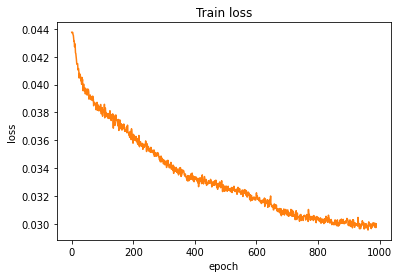

In [ ]:
# Loss
checkpoints = {int(checkpoint.replace('.pth', '')): checkpoint
          for checkpoint in os.listdir('/content/c/content/drive/My Drive/checkpoint_regression')
          if 'best' not in checkpoint}
train_losses = []
test_losses = []
for key in sorted(list(checkpoints.keys()))[10:]:
  checkpoint = checkpoints[key]
  state = torch.load(os.path.join('/content/c/content/drive/My Drive/checkpoint_regression', checkpoint), map_location='cpu')
  print(state)
  test_losses.append(state['train_loss'])

plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Train loss')
plt.xlabel('epoch')
plt.ylabel('loss')

{'epoch': 0, 'train_loss': 0.04403679529675685, 'test_loss': 0.04576013720996007}
{'epoch': 1, 'train_loss': 0.04400132081955742, 'test_loss': 0.045564949794968154}
{'epoch': 2, 'train_loss': 0.043846501062994134, 'test_loss': 0.04582546842041739}
{'epoch': 3, 'train_loss': 0.04372974691044119, 'test_loss': 0.04578716890506835}
{'epoch': 4, 'train_loss': 0.04384508840194219, 'test_loss': 0.045952992416671105}
{'epoch': 5, 'train_loss': 0.043825887259752276, 'test_loss': 0.04614037190568391}
{'epoch': 6, 'train_loss': 0.04371988931015296, 'test_loss': 0.04561005977657734}
{'epoch': 7, 'train_loss': 0.0436623489513226, 'test_loss': 0.04571776791206468}
{'epoch': 8, 'train_loss': 0.0437344042377535, 'test_loss': 0.0459003812893872}
{'epoch': 9, 'train_loss': 0.043619066631675724, 'test_loss': 0.04531519870622463}
{'epoch': 10, 'train_loss': 0.043530321650534345, 'test_loss': 0.04547610949566014}
{'epoch': 11, 'train_loss': 0.043362408299236634, 'test_loss': 0.04571556621253208}
{'epoch': 

Text(0, 0.5, 'loss')

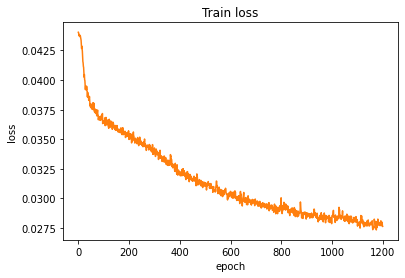

In [ ]:
# Loss
checkpoints = {int(checkpoint.replace('.pth', '')): checkpoint
          for checkpoint in os.listdir(regression_checkpoint_dir)
          if 'best' not in checkpoint}
train_losses = []
test_losses = []
for key in sorted(list(checkpoints.keys())):
  checkpoint = checkpoints[key]
  state = torch.load(os.path.join(regression_checkpoint_dir, checkpoint), map_location='cpu')
  print(state)
  test_losses.append(state['train_loss'])

plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Train loss')
plt.xlabel('epoch')
plt.ylabel('loss')

#### Save checkpoints to zip file

In [ ]:
!zip -r checkpoint_regression_128x128_128_1000.zip /content/drive/My\ Drive/checkpoint_regression
!mv checkpoint_regression_128x128_128_1000.zip /content/drive/My\ Drive/checkpoint_regression_128x128_128_1000.zip

  adding: content/drive/My Drive/checkpoint_regression/ (stored 0%)
  adding: content/drive/My Drive/checkpoint_regression/541.pth (deflated 55%)
  adding: content/drive/My Drive/checkpoint_regression/542.pth (deflated 55%)
  adding: content/drive/My Drive/checkpoint_regression/543.pth (deflated 55%)
  adding: content/drive/My Drive/checkpoint_regression/544.pth (deflated 55%)
  adding: content/drive/My Drive/checkpoint_regression/545.pth (deflated 55%)
  adding: content/drive/My Drive/checkpoint_regression/546.pth (deflated 55%)
  adding: content/drive/My Drive/checkpoint_regression/547.pth (deflated 55%)
  adding: content/drive/My Drive/checkpoint_regression/548.pth (deflated 55%)
  adding: content/drive/My Drive/checkpoint_regression/549.pth (deflated 55%)
  adding: content/drive/My Drive/checkpoint_regression/550.pth (deflated 55%)
  adding: content/drive/My Drive/checkpoint_regression/551.pth (deflated 55%)
  adding: content/drive/My Drive/checkpoint_regression/552.pth (deflated 5